In [1]:
import re
import json
import time
import numpy as np
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from itertools import chain
import pydeck as pdk
from bs4 import BeautifulSoup

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

In [3]:
#!pip install SPARQLWrapper

### SPARQL queries

In [4]:
### Create SPARQL query
### Resource: https://query.wikidata.org/

def get_all_wiki_data(query_template, limit=5000):
    all_results = []
    offset = 0
    
    while True:
        # Add LIMIT and OFFSET to the query
        current_query = query_template + f" LIMIT {limit} OFFSET {offset}"
        #print(current_query)
        
        # Get results for current page
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        sparql.setQuery(current_query)
        sparql.setReturnFormat(JSON)
        sparql.addCustomHttpHeader("User-Agent", "MySPARQLQueryBot/1.0 (your_email@example.com)")
        
        try:
            results = sparql.query().convert()
            #response = sparql.query().response.read().decode("utf-8")  # Decode the response as UTF-8
            #data = json.loads(response)
            #results = data["results"]["bindings"]
            bindings = results["results"]["bindings"]
            
            # If no results returned, we've reached the end
            if not bindings:
                break
                
            all_results.extend(bindings)
            
            # Move to next page
            offset = offset + limit
            print(f"Retrieved {len(bindings)} results (offset {offset})")
            
            # Optional: add a small delay to be nice to the server
            #print("Processed:", offset)
            time.sleep(0.1)
            if offset>60000:
                break
            
        except Exception as e:
            print(f"Error at offset {offset}: {e}")
            continue
    
    return all_results

# Then call the function
#results_uk = get_all_wiki_data(query_uk)

def get_wiki_data(query):

    # Define SPARQL endpoint
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    
    headers = {
        "User-Agent": "MySPARQLQueryBot/1.0 (your_email@example.com)"  # Use your own email for compliance
    }
    
    # Create a SPARQLWrapper instance
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader("User-Agent", "MySPARQLQueryBot/1.0 (your_email@example.com)")
    
    ### Get Responce from WIKI query service
    response = sparql.query().response.read().decode("utf-8")  # Decode the response as UTF-8
    
    ### Convert to JSON
    data = json.loads(response)
    results = data["results"]["bindings"]
    return results

In [5]:
query_other = '''
SELECT DISTINCT ?person ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel 
WHERE {
  ?person wdt:P31 wd:Q5.  # instance of human

  # Ukraine-related countries/entities
  VALUES ?ukraineRelatedEntity {
    wd:Q133356   # Ukrainian Soviet Socialist Republic
    wd:Q243610   # Ukrainian People's Republic
    wd:Q1508143  # Українська держава
    wd:Q457167   # ЗУНР
    wd:Q950644   # Карпатська Україна
    wd:Q210119   # Ruthenia
    wd:Q1282093  # Subcarpathian Rus’
    wd:Q2418795  # Запорозька Січ
    wd:Q212439   # Cossack Hetmanate
    wd:Q133354   # Ukrainian State (Hetmanate)
    wd:Q239502   # Галицько Волинське Князівство
    wd:Q2396442  # Королівство Галичини і Володимирії
    wd:Q1108445  # Київська Русь
  }

  # Person must match at least one of the following:
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # citizenship
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # born in a Ukraine-related place
  }

  # Wikipedia article in Ukrainian
  ?wikipedia schema:about ?person;
             schema:isPartOf <https://uk.wikipedia.org/>.

  # Birth info
  ?person wdt:P19 ?birthPlace.
  ?birthPlace wdt:P625 ?coordinates.
  ?person wdt:P569 ?birthDate.

  # Optional death info
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                     ?deathPlace wdt:P625 ?coordinates_death. }
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  OPTIONAL { ?person wdt:P21 ?sex. }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
LIMIT 35000
'''

In [6]:
query_ethnic = """
SELECT DISTINCT ?person ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel ?coordinates_death
         ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel 
WHERE {
  ?person wdt:P31 wd:Q5.  # instance of human

  # Ukrainian-related ethnic groups
  VALUES ?ethnicity {
    wd:Q44806      # Ukrainians
    wd:Q140420     # Ruthenians, Lemkos
    wd:Q891187     # Boykos
    wd:Q828398     # Hutsuls
    wd:Q117458     # Crimean Tatars
    wd:Q63075063   # Jews in Ukraine
    wd:Q260152     # Greeks in Ukraine
    wd:Q726205     # Hungarians in Ukraine
    wd:Q2025325    # Romanians in Ukraine
    wd:Q3692570    # Belarusians in Ukraine
    wd:Q3317172    # Romani people in Ukraine
    wd:Q12160131   # Tatars in Ukraine
    wd:Q12108632   # Karaims in Ukraine
    
    wd:Q1976275       # Ukrainian Argentine
    wd:Q1976298       # Ukrainian Canadians
    wd:Q2737211       # Ukrainian Brazilians
    wd:Q2505231       # Ukrainian Americans
    wd:Q2387354       # Ukrainian Australians
  }

  {
    ?person wdt:P172 ?ethnicity.              # belongs to target ethnic group
  }
  # Wikipedia article in Ukrainian
  ?wikipedia schema:about ?person;
             schema:isPartOf <https://uk.wikipedia.org/>.

  # Birth info
  ?person wdt:P19 ?birthPlace.
  ?birthPlace wdt:P625 ?coordinates.
  ?person wdt:P569 ?birthDate.

  # Optional death info
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                     ?deathPlace wdt:P625 ?coordinates_death. }
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  OPTIONAL { ?person wdt:P21 ?sex. }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
LIMIT 35000
"""

In [7]:
query_uk1 = '''
SELECT ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel
WHERE {
  ?person wdt:P31 wd:Q5.

  # Country/entities to check
  VALUES ?ukraineRelatedEntity {
    wd:Q212    # Ukraine
  }

  # Any of these properties point to one of the target entities
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # nationality
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # Народжений в 
  }
  
  ?wikipedia schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.

  ?person wdt:P19 ?birthPlace.
    ?birthPlace wdt:P625 ?coordinates.
    
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                             ?deathPlace wdt:P625 ?coordinates_death.}
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  ?person wdt:P569 ?birthDate.

  FILTER(YEAR(?birthDate) >= %s && YEAR(?birthDate) < %s)
  
  OPTIONAL { ?person wdt:P21 ?sex. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
LIMIT 15000 
'''

In [8]:
query_temp = '''
SELECT ?personLabel ?birthPlaceLabel ?birthDate ?coordinates ?deathPlaceLabel 
        ?coordinates_death ?deathDate ?wikipedia ?sexLabel ?ukraineRelatedEntityLabel
WHERE {
  ?person wdt:P31 wd:Q5.

  # Country/entities to check
  VALUES ?ukraineRelatedEntity {
    wd:Q212    # Ukraine
  }

  # Any of these properties point to one of the target entities
  {
    ?person wdt:P27 ?ukraineRelatedEntity.    # nationality
  }
  UNION {
    ?person wdt:P19 ?placeOfBirth.
    ?placeOfBirth wdt:P17 ?ukraineRelatedEntity.  # Народжений в 
  }
  
  ?wikipedia schema:about ?person;
            schema:isPartOf <https://uk.wikipedia.org/>.

  ?person wdt:P19 ?birthPlace.
    ?birthPlace wdt:P625 ?coordinates.
    
  OPTIONAL { ?person wdt:P20 ?deathPlace. 
                             ?deathPlace wdt:P625 ?coordinates_death.}
  OPTIONAL { ?person wdt:P570 ?deathDate. }

  ?person wdt:P569 ?birthDate.

  FILTER(YEAR(?birthDate) >= %s && YEAR(?birthDate) <= %s)
  
  OPTIONAL { ?person wdt:P21 ?sex. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "uk". }
}
'''

### Extract data from DataWiki

In [927]:
query1 = query_uk1 % (1000, 1900)
query2 = query_uk1 % (1900, 1925)

### Query result for Ukraine
results_uk1 = get_wiki_data(query=query1)
print('Count1:', len(results_uk1))

### Query result for Ukraine
time.sleep(20)
results_uk2 = get_wiki_data(query=query2)
print('Count2:', len(results_uk2))

Count1: 11470
Count2: 12998


In [926]:
delta = 5
results_uk = []
for i in range(0, 30):
    t1 = 1925+(i*delta)
    t2 = 1930+(i*delta)
    query = query_temp % (t1, t2)

    temp = get_wiki_data(query=query)
    results_uk.extend(temp)
    print(t1, t2,'Count:', len(temp))
    time.sleep(20)
    if t2>2025:
        break

1925 1930 Count: 6419
1930 1935 Count: 5911
1935 1940 Count: 8965
1940 1945 Count: 6052
1945 1950 Count: 8908
1950 1955 Count: 8302
1955 1960 Count: 8810
1960 1965 Count: 8517
1965 1970 Count: 8328
1970 1975 Count: 10915
1975 1980 Count: 11498
1980 1985 Count: 11357
1985 1990 Count: 11241
1990 1995 Count: 10415
1995 2000 Count: 5452
2000 2005 Count: 2137
2005 2010 Count: 288
2010 2015 Count: 29
2015 2020 Count: 4
2020 2025 Count: 0
2025 2030 Count: 0


In [923]:
### Query result for Others Ukraine related countries
results_others = get_wiki_data(query=query_other)
print('Count others:', len(results_others))

Count others: 5630


In [933]:
### Query result for Ethnics
results_ethnic = get_wiki_data(query=query_ethnic)
print('Count ethnic:', len(results_ethnic))

Count ethnic: 379


In [934]:
results_all = []
results_all.extend(results_uk1)
results_all.extend(results_uk2)
results_all.extend(results_uk)

results_all.extend(results_others)
results_all.extend(results_ethnic)

print('Count:', len(results_all))
print('Count for others:', len(results_others))

Count: 164025
Count for others: 5630


### Preprocess data

In [943]:
# Convert results to a pandas DataFrame
df = pd.DataFrame([
    {
        "Coordinates": item.get("coordinates", {}).get("value", ""),
        "PersonName": item.get("personLabel", {}).get("value", ""),
        "BirthPlace": item.get("birthPlaceLabel", {}).get("value", ""),
        "BirthDate": item.get("birthDate", {}).get("value", ""),
        "DeathDate": item.get("deathDate", {}).get("value", ""),
        "DeathPlace": item.get("deathPlaceLabel", {}).get("value", ""),
        "Coordinates_death": item.get("coordinates_death", {}).get("value", ""),
        "Sex": item.get("sexLabel", {}).get("value", ""),
        "WikipediaURL": item.get("wikipedia", {}).get("value", ""),
        "Affiliation": item.get("ukraineRelatedEntityLabel", {}).get("value", "Україна"),
    }
    for item in results_all
])


### Drop duplicates
df = df.drop_duplicates(['PersonName','WikipediaURL'])

### Save data to Excel
# df.to_excel("ukraininans_wiki_data.xlsx", index=False)

print('Dataframe size: ', df.shape)

Dataframe size:  (61171, 10)


In [42]:
df.to_excel("ukraininans_wiki_data.xlsx", index=False)

In [301]:
df = pd.read_excel("ukraininans_wiki_data.xlsx")
df_petscan = pd.read_excel("petscan_data.xlsx")
df = df._append(df_petscan).fillna('').drop_duplicates(['PersonName','WikipediaURL']).reset_index(drop=True)
print('Df total size:', df.shape[0])

print('Df death size:', df[df.DeathPlace!=''].shape[0])

Df total size: 61824
Df death size: 26713


In [244]:
### Columns manipulation
def is_valid_date(date_string):
    try:
        pd.Timestamp(date_string)
        return True
    except ValueError:
        return False

def convert_to_date(date_string):
    try:
        return str(pd.Timestamp(date_string).date())
    except:
        return 'не вказано'

### For bithdate dataframe
df['Lon'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df.Coordinates]
df['Lat'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df.Coordinates]
#df['Birthday_check'] = [is_valid_date(x) for x in df.BirthDate]
#df = df[df.Birthday_check==True].drop('Birthday_check', axis=1)
#df['Birthday'] = [str(pd.Timestamp(x).date()) for x in df.BirthDate]
df['Birthday'] = [convert_to_date(x) for x in df.BirthDate]

cord_df = df[['Lat','Lon','PersonName','BirthPlace','Birthday', 'Sex','WikipediaURL','Affiliation']]

In [304]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
    R = 6371.0

    lat1, lon1 = map(math.radians, (lat1,lon2))
    lat2, lon2 = map(math.radians, (lat2,lon2))

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in kilometers

### Define death dataframe
df_death = df[df.DeathPlace!='']

### For deathday dataframe
df_death.Coordinates_death = df_death.Coordinates_death.fillna('')
df_death = df_death[df_death.Coordinates_death.str.contains('Point')]
df_death['Lon'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df_death.Coordinates]
df_death['Lat'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df_death.Coordinates]
df_death['Lon_death'] = [float(re.findall(r"Point\((-?\d+.\d+)", x)[0]) for x in df_death.Coordinates_death]
df_death['Lat_death'] = [float(re.findall(r"Point\(-?\d+.\d+\s+(-?\d+.\d+)", x)[0]) for x in df_death.Coordinates_death]
df_death['Birthday'] = [convert_to_date(x) for x in df_death.BirthDate]
df_death['DeathDate'] = [convert_to_date(x) for x in df_death.DeathDate]
df_death['Distance'] = [haversine(x1,y1, x2,y2) for x1,y1,x2,y2 in zip(df_death.Lat,df_death.Lon, df_death.Lat_death,df_death.Lon_death)]
df_death['SamePlace'] = np.where(df_death.BirthPlace==df_death.DeathPlace, 1, 0)

df_death = df_death.drop(['Lat','Lon'], axis=1)
df_death = df_death.rename(columns={'Lat_death':'Lat', 'Lon_death':'Lon'})
df_death = df_death[['Lat','Lon','PersonName','Birthday',
                          'BirthPlace','DeathDate','DeathPlace','Distance','SamePlace', 'Sex','WikipediaURL','Affiliation']]

In [305]:
print(cord_df.shape)
cord_df.head()

(61824, 12)


,Lat,Lon,PersonName,BirthPlace,Birthday,Sex,WikipediaURL,Affiliation,Temp,Size,Lon2,Lat2
0,47.664436,36.263172,Махно Нестор Іванович,Гуляйполе,1888-11-07,чоловіча,https://uk.wikipedia.org/wiki/%D0%9C%D0%B0%D1%...,Україна,Гуляйполе3647,34,36.274477,47.653017
1,49.891944,28.600000,Джозеф Конрад,Бердичів,1857-12-03,чоловіча,https://uk.wikipedia.org/wiki/%D0%94%D0%B6%D0%...,Україна,Бердичів2849,136,28.591364,49.874379
2,50.450000,30.523611,Григорій Васильович Шварц-Бостуніч,Київ,1883-12-01,чоловіча,https://uk.wikipedia.org/wiki/%D0%93%D1%80%D0%...,Україна,Київ3050,5272,30.595091,50.453736
3,49.000000,32.000000,Ольга Зеглер,Україна,1881-07-31,жіноча,https://uk.wikipedia.org/wiki/%D0%9E%D0%BB%D1%...,Україна,Україна3249,265,31.947828,49.046792
4,50.155000,25.195833,Лео Каннер,Клекотів,1894-06-13,чоловіча,https://uk.wikipedia.org/wiki/%D0%9B%D0%B5%D0%...,Україна,Клекотів2550,1,25.191025,50.152766


### Gender Distribution

In [306]:
gender_freq = pd.DataFrame(cord_df[~cord_df.Sex.isin(['','Q121307100'])].Sex.value_counts()).reset_index()
gender_freq.columns = ['Gender','Count']
gender_freq['Percent'] = 100*gender_freq.Count/gender_freq.Count.sum()
gender_freq

,Gender,Count,Percent
0,чоловіча,50848,82.348940
1,жіноча,10895,17.644582
2,транс-жінка,3,0.004859
3,небінарність,1,0.001620


In [307]:
### Select cases where gender != male or female
cord_df[~cord_df.Sex.isin(['чоловіча','жіноча','','Q121307100', np.nan])]

,Lat,Lon,PersonName,BirthPlace,Birthday,Sex,WikipediaURL,Affiliation,Temp,Size,Lon2,Lat2
49347,50.450000,30.523611,Діва Монро,Київ,1978-01-13,транс-жінка,https://uk.wikipedia.org/wiki/%D0%94%D1%96%D0%...,Україна,Київ3050,5272,30.474267,50.349566
49987,49.000000,32.000000,Р. Б. Лемберґ,Україна,1976-09-27,небінарність,https://uk.wikipedia.org/wiki/%D0%A0._%D0%91._...,Україна,Україна3249,265,31.925536,48.992500
54246,45.503056,32.705000,Зіанджа,Чорноморське,1990-12-12,транс-жінка,https://uk.wikipedia.org/wiki/Zi_Fa%C3%A1melu,Україна,Чорноморське3245,2,32.717454,45.500009
57117,48.467500,35.040000,Став Страшко,Дніпро,1992-09-24,транс-жінка,https://uk.wikipedia.org/wiki/%D0%A1%D1%82%D0%...,Україна,Дніпро3548,1231,35.050623,48.452062


### Affiliation Distribution

In [308]:
### Affiliation Distribution
affiliation_freq = pd.DataFrame(cord_df.Affiliation.value_counts()).reset_index()
affiliation_freq.columns = ['Affiliation','Count']
affiliation_freq['Percent'] = 100*affiliation_freq.Count/affiliation_freq.Count.sum()
affiliation_freq

,Affiliation,Count,Percent
0,Україна,61025,98.707622
1,Українська Радянська Соціалістична Республіка,416,0.672878
2,Українська Народна Республіка,232,0.375259
3,Західноукраїнська Народна Республіка,34,0.054995
4,Сполучені Штати Америки,20,0.032350
5,Українська Держава,13,0.021027
6,Київська Русь,12,0.019410
7,Гетьманщина,12,0.019410
8,Канада,11,0.017792
9,Союз Радянських Соціалістичних Республік,9,0.014557


### Birth place ~ death place distance distribution

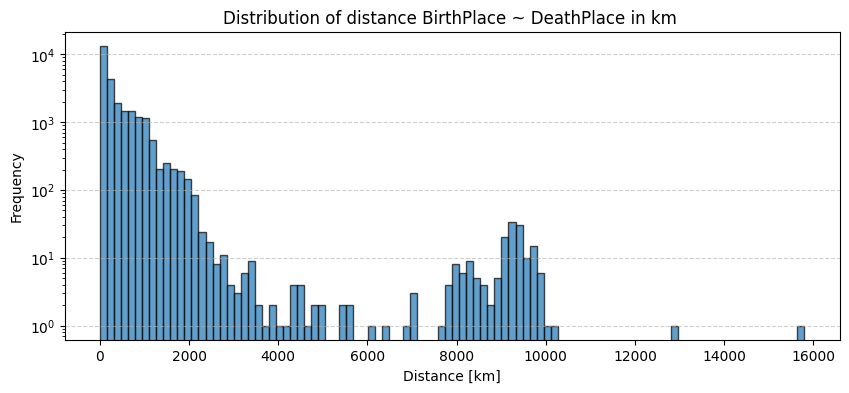

In [309]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
ax.hist(death_cord_df["Distance"], bins=100, edgecolor="black", alpha=0.7)
ax.set_yscale('log')
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Frequency")
ax.set_title('Distribution of distance BirthPlace ~ DeathPlace in km ')
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

#### Distribution of SamePlace 
**1 - if birth palce = death place, otherwise = 0**

In [310]:
### Distribution of SamePlace = 1 - if bith palce = death place otherwise 0
same_place_dist = pd.DataFrame(death_cord_df.SamePlace.value_counts(normalize=False)).reset_index(names='SamePlace')
same_place_dist = same_place_dist.rename(columns={'count':'Count'})
same_place_dist['Percent'] = same_place_dist.Count/same_place_dist.Count.sum()
same_place_dist.Percent = same_place_dist.Percent*100
same_place_dist

,SamePlace,Count,Percent
0,0,23867,89.349356
1,1,2845,10.650644


In [311]:
### Process SPARQL response and add small noise for observations with same coordinates
mu, sigma = 0, 0.02
min_sigma = 0.005

delta = 160
cord_df['Temp'] = cord_df.BirthPlace+cord_df.Lon.astype(int).astype(str)+cord_df.Lat.astype(int).astype(str)
cord_df['Size'] = cord_df.groupby('Temp')['PersonName'].transform('count')

#scale = (np.log1p(cord_df['Size']).clip(lower=0) / (delta-cord_df['Size']**0.5))
scale = np.log1p(cord_df['Size']) / delta 
noise_lon = np.random.normal(mu, scale)
noise_lat = np.random.normal(mu, scale)

cord_df['Lon2'] = cord_df['Lon'] + noise_lon
cord_df['Lat2'] = cord_df['Lat'] + noise_lat

cord_noise_df = cord_df.drop(['Temp','Size'], axis=1).reset_index(drop=True)
cord_noise_df.Lat = cord_noise_df.Lat.round(4)
cord_noise_df.Lon = cord_noise_df.Lon.round(4)

In [312]:
### Process SPARQL response and add small noise for observations with same coordinates for death df
mu, sigma = 0, 0.02
min_sigma = 0.005

delta = 160
df_death['Temp'] = df_death.DeathPlace+df_death.Lon.astype(int).astype(str)+df_death.Lat.astype(int).astype(str)
df_death['Size'] = df_death.groupby('Temp')['PersonName'].transform('count')

scale = np.log1p(df_death['Size']) / delta 
noise_lon = np.random.normal(mu, scale)
noise_lat = np.random.normal(mu, scale)

df_death['Lon2'] = df_death['Lon'] + noise_lon
df_death['Lat2'] = df_death['Lat'] + noise_lat

death_cord_noise_df = df_death.drop(['Temp','Size'], axis=1).reset_index(drop=True)
death_cord_noise_df.Lat = death_cord_noise_df.Lat.round(4)
death_cord_noise_df.Lon = death_cord_noise_df.Lon.round(4)

## Interactive Maps

In [313]:
map_template = """
<!DOCTYPE html>
<html>
<head>
  <meta charset="UTF-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
  <title>{title}</title>
  <script src="https://unpkg.com/deck.gl@8.9.27/dist.min.js"></script>
  <script src="https://api.mapbox.com/mapbox-gl-js/v2.13.0/mapbox-gl.js"></script>
  <link href="https://api.mapbox.com/mapbox-gl-js/v2.13.0/mapbox-gl.css" rel="stylesheet" />
  <style>
    html, body {{
      margin: 0;
      padding: 0;
      height: 100%;
      width: 100%;
      overflow: hidden;
    }}

    #map {{
      position: absolute;
      top: 0;
      left: 0;
      height: 100%;
      width: 100%;
    }}

    #map canvas {{
      cursor: crosshair !important;
    }}

    .mapboxgl-ctrl-logo,
    .mapboxgl-ctrl-attrib {{
      display: none !important;
    }}

    #search-bar {{
      position: absolute;
      bottom: 15px;
      left: 15px;
      z-index: 1000;
    }}

    #searchInput {{
      padding: 6px 8px;
      font-size: 13px;
      border: none;
      border-radius: 5px;
      background-color: #007bff;
      color: #ffffff;
      width: 220px;
      cursor: pointer;
      transition: all 0.2s ease-in-out;
      box-shadow: 0 0 0 3px rgba(0, 123, 255, 0.4);
    }}

    #searchInput::placeholder {{
      color: #d9e9ff;
      opacity: 1;
    }}

    #searchInput:focus {{
      background-color: #0056b3;
      border-color: #66b2ff;
      outline: none;
      box-shadow: 0 0 0 3px rgba(0, 123, 255, 0.4);
    }}
  </style>
</head>
<body>
  <div id="map"></div>
  <div id="search-bar">
    <input id="searchInput" type="text" placeholder="🔍Пошук за іменем та прізвищем" />
  </div>
  <script>
    const originalData = {originalData};

    const isMobile = /iPhone|iPad|iPod|Android/i.test(navigator.userAgent);

    const defaultViewState = isMobile
      ? {{
          longitude: 33,
          latitude: 50,
          zoom: 3,
          minZoom: 0,
          maxZoom: 20
        }}
      : {{
          longitude: 55,
          latitude: 50,
          zoom: 3.2,
          minZoom: 0,
          maxZoom: 20
        }};

    const searchInput = document.getElementById('searchInput');

    const scatterLayer = data => new deck.ScatterplotLayer({{
      id: 'scatterplot',
      data,
      getPosition: d => [d.Longitude, d.Latitude],
      getRadius: 1,
      radiusScale: 60,
      radiusMinPixels: 1.4,
      radiusMaxPixels: 1000,
      lineWidthMinPixels: 1,
      getFillColor: [255, 130, 0],
      pickable: true,
      opacity: 0.6,
      stroked: true,
      filled: true,
      extruded: false,
      wireframe: true,
      autoHighlight: true,
      onClick: info => {{
        if (info.object && info.object.WikipediaURL) {{
          window.open(info.object.WikipediaURL, "_blank");
        }}
      }}
    }});

    const getTooltip = ({{object}}) => {{
      return object ? {{
        html: `
        <div style="background-color: rgba(34, 42, 55, 0.95); color: #fff; padding: 10px; border-radius: 5px; font-size: 12px; font-family: sans-serif; max-width: 300px;">
          <div><b>Ім'я:</b><br>${{object.PersonName}}</div>
          <div><b>Місце народження:</b><br>${{object.BirthPlace}}</div>
          <div><b>Дата народження:</b><br>${{object.Birthday}}</div>
          <div><b>Довгота:</b><br>${{object.Longitude}}</div>
          <div><b>Широта:</b><br>${{object.Latitude}}</div>
        </div>
      `,
        style: {{
          backgroundColor: "rgba(0, 0, 0, 0)",
          color: "#fff",
          fontSize: "11px"
        }}
      }} : null;
    }};

    let deckgl = new deck.DeckGL({{
      container: 'map',
      mapStyle: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json',
      initialViewState: defaultViewState,
      controller: true,
      getTooltip,
      layers: [scatterLayer(originalData)],
      parameters: {{
        mapbox: false
      }},
      attributionControl: false
    }});

    searchInput.addEventListener('input', () => {{
      const query = searchInput.value.toLowerCase();
      const filteredData = query
        ? originalData.filter(d => d.PersonName.toLowerCase().includes(query))
        : originalData;

      deckgl.setProps({{
        layers: [scatterLayer(filteredData)]
      }});
    }});
  </script>
</body>
</html>
"""

### Interactive Visualisation with Pydeck of ukrainians Birth Places

In [314]:
### Prepare datafrmae with coordinates
birth_cord_df = cord_noise_df[['Lon2','Lat2','PersonName','BirthPlace','Birthday', 'WikipediaURL']]
birth_cord_df = birth_cord_df.rename(columns={'Lat2':'Latitude', 'Lon2':'Longitude'})
birth_cord_df[['Latitude','Longitude']] = birth_cord_df[['Latitude','Longitude']].round(4)

js_data = birth_cord_df.to_dict(orient='records')
js_code = json.dumps(js_data, ensure_ascii=False) 

html_content = map_template.format(title='Map birth places', originalData=js_code)

# Save it as UTF-8 to preserve characters
with open("./data/birth_search.html", "w", encoding="utf-8") as f:
    f.write(html_content)

### Interactive Visualisation with Pydeck of ukrainians Death Places

In [315]:
### Prepare datafrmae with coordinates
death_cord_df = death_cord_noise_df[['Lon2','Lat2','PersonName','BirthPlace','Birthday','DeathPlace',
                                     'DeathDate','Distance','Sex','SamePlace','WikipediaURL']]
death_cord_df = death_cord_df.rename(columns={'Lat2':'Latitude', 'Lon2':'Longitude'})
death_cord_df[['Latitude','Longitude']] = death_cord_df[['Latitude','Longitude']].round(4)

js_data = death_cord_df.to_dict(orient='records')
js_code = json.dumps(js_data, ensure_ascii=False) 

html_death_content = map_template.format(title='Map birth places', originalData=js_code)

# Save it as UTF-8 to preserve characters
with open("./data/death_search.html", "w", encoding="utf-8") as f:
    f.write(html_death_content)

### Statistic Page

In [316]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd 
from plotly.io import to_html

### Locations Distribution

In [317]:
birthplace_freq = pd.DataFrame(cord_df.BirthPlace.value_counts()).reset_index()
birthplace_freq.columns = ['BirthPlace','Count']
birthplace_freq['Percent'] = 100*birthplace_freq.Count/birthplace_freq.Count.sum()
birthplace_freq = birthplace_freq.head(30)

# Create bar chart (more suitable than histogram for categorical data)
locations_dist_fig = px.bar(
    birthplace_freq,
    x='BirthPlace',
    y='Count',
    text='Count',
    hover_data={'BirthPlace': True, 'Count': True, 'Percent': ':.2f'},
    color_discrete_sequence=['steelblue']
)

locations_dist_fig.update_traces(textposition='outside')

# Create customdata as a 2D array (each row: [Count, Percent])
customdata = np.array(list(zip(birthplace_freq['Count'], birthplace_freq['Percent'])))

# Update hover info
locations_dist_fig.update_traces(
    hovertemplate='Місце народження: %{x}<br>Відсоток: %{customdata[1]:.2f}%<br>Кількість: %{customdata[0]}<extra></extra>',
    customdata=customdata
)

# Apply dark theme and style
locations_dist_fig.update_layout(
    height=500,
    margin=dict(t=90, b=20, l=1,r=4),
    template='plotly_dark',
    #title='TОП 30 локацій народженнь',
    title=("<span style='font-size:16px;'><b>TОП 30 локацій народжень<br></b></span>"
          "<span style='font-size:12px;'>Враховано лише статті з вказаним місцем народження</span>"),
    yaxis_title='Кількість',
    xaxis_title='',
    autosize=True,
    dragmode=False
)

_ = None

### Distance distribution

In [318]:
# Create histogram
hist = go.Figure(
    go.Histogram(
        x=death_cord_df["Distance"],
        xbins=dict(
            start=0,                   # ⛔️ No negative bins
            end=death_cord_df["Distance"].max(),
            size=100                  # Bin width (adjust as needed)
        ),
        marker_color='steelblue'
    )
)

hist.update_traces(
    hovertemplate=
    'Відстань: %{x} [км]<br>' +
    'Кількість: %{y}<extra></extra>'  # <extra></extra> removes secondary box
)
hist.update_layout(
    template='plotly_dark',
    #width=None, 
    height=None,
    #height=400,
    margin=dict(t=70, b=20, l=1, r=5),
    title=("<span style='font-size:20px;'>Розподіл відстані між місцем народження та смерті [км].<br></span>"
           "<span style='font-size:14px;'>Враховано лише ті сторінки Вікіпедії, на яких було вказано місце народження і смерті відповідно.</span>"),
    yaxis_title="Кількість [log]",
    xaxis_title='Відстань [км]',
    yaxis_type="log",
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
    autosize=True,
    dragmode=False
)

_ = None

### Pie Charts

In [319]:
### Sex distribution
cord_df.Sex = cord_df.Sex.fillna('')
sex_dist = pd.DataFrame(cord_df[(cord_df.Sex!='') & (~cord_df.Sex.str.contains('Q'))].Sex.value_counts(normalize=False)).reset_index(names='Sex')
sex_dist = sex_dist.rename(columns={'count':'Count'})
sex_dist['Percent'] = sex_dist.Count/sex_dist.Count.sum()
sex_dist.Percent = (sex_dist.Percent*100).round(4)

### Distribution of same place of birth and death or not
same_place_dist["SamePlace_cat"] = same_place_dist["SamePlace"].map({1: "Місце народження і смерті одинакові", 0: "Місце народження і смерті різні"})

In [320]:
### Create dataframe by gender for detecting distribution of same place birth and death or no
same_place_sex_dist = death_cord_df[death_cord_df.Sex.isin(['чоловіча','жіноча'])][['Sex','SamePlace']]
same_place_sex_dist['Count'] = 1
same_place_sex_dist = same_place_sex_dist.groupby(['Sex','SamePlace'], as_index=False).sum()
same_place_sex_dist['Count_sex'] = same_place_sex_dist.groupby('Sex')['Count'].transform('sum')
same_place_sex_dist['Percent'] = 100*same_place_sex_dist.Count/same_place_sex_dist.Count_sex
same_place_sex_dist = same_place_sex_dist.drop(['Count_sex'], axis=1)
same_place_sex_dist["SamePlace_cat"] = same_place_sex_dist["SamePlace"].map({1: "Місце народження і смерті одинакові", 
                                                                             0: "Місце народження і смерті різні"})
same_place_sex_dist

,Sex,SamePlace,Count,Percent,SamePlace_cat
0,жіноча,0,2503,83.712375,Місце народження і смерті різні
1,жіноча,1,487,16.287625,Місце народження і смерті одинакові
2,чоловіча,0,21340,90.049793,Місце народження і смерті різні
3,чоловіча,1,2358,9.950207,Місце народження і смерті одинакові


In [321]:

# PIE 1 — Sex Distribution
pie_sex = px.pie(
    sex_dist,
    names="Sex",
    values="Percent",
    title=None,
    hover_data={"Percent": True, "Sex": False, "Count": True}
)

pie_sex.update_traces(
    hovertemplate='Гендер: %{label}<br>Відсоток: %{percent}%<br>Кількість: %{customdata[0]}<extra></extra>',
    customdata=sex_dist["Count"]
)

pie_sex.update_layout(
    margin=dict(t=80, b=10, l=1, r=1),
    template="plotly_dark",
    title=None,
    font=dict(size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    autosize=True
)

# PIE 2 — Same Place Distribution
pie_same_place = px.pie(
    same_place_dist,
    names="SamePlace_cat",
    values="Percent",
    title=None,
    color_discrete_sequence=["steelblue", "orange"],
    hover_data={"Percent": True, "SamePlace_cat": False, "Count": True}
)

pie_same_place.update_traces(
    customdata=same_place_dist["Count"],
    hovertemplate='Категорія: %{label}<br>Відсоток людей: %{percent}<br>Кількість: %{customdata[0]}<extra></extra>'
)

pie_same_place.update_layout(
    margin=dict(t=80, b=10, l=1, r=1),
    template="plotly_dark",
    title=None,
    font=dict(size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    autosize=True
)

# COMBINED PIES
pie_combined = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    horizontal_spacing=0.4
)

# Add Traces
pie_combined.add_trace(go.Pie(
    labels=sex_dist["Sex"],
    values=sex_dist["Percent"],
    customdata=sex_dist["Count"],
    name="Гендер",
    hovertemplate='Гендер: %{label}<br>Відсоток: %{percent}%<br>Кількість: %{customdata[0]}<extra></extra>',
    showlegend=True
), row=1, col=1)

pie_combined.add_trace(go.Pie(
    labels=same_place_dist["SamePlace_cat"],
    values=same_place_dist["Percent"],
    customdata=same_place_dist["Count"],
    name="Місце",
    hovertemplate='Категорія: %{label}<br>Відсоток людей: %{percent}<br>Кількість: %{customdata[0]}<extra></extra>',
    marker=dict(colors=["steelblue", "orange"]),
    showlegend=True
), row=1, col=2)

# Layout Updates
pie_combined.update_layout(
    annotations=[
        dict(
            text=(
                "<b>Розподіл за гендером</b><br>"
                "<span style='font-size:0.8em; max-width:120px; display:inline-block; text-align:center;'>"
                "Враховано лише статті із вказаним гендером,<br>місцем і датою народження"
                "</span>"
            ),
            x=0.20, y=1.08, xref='paper', yref='paper',
            showarrow=False, align="left",
            xanchor="center", yanchor="bottom"
        ),
        dict(
            text=(
                "<b>Порівняння місця народження і смерті</b><br>"
                "<span style='font-size:0.8em; max-width:120px; display:inline-block; text-align:center;'>"
                "Враховано лише статті із вказаним<br>місцем народження та смерті"
                "</span>"
            ),
            x=0.80, y=1.08, xref='paper', yref='paper',
            showarrow=False, align="right",
            xanchor="center", yanchor="bottom"
        )
    ],
    template="plotly_dark",
    font=dict(size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    margin=dict(t=100, b=10, l=2, r=2),
    autosize=True,
    height=400,
    width=None,
    dragmode=False
)

pie_combined.update_traces(hole=0.4)
_ = None

In [322]:
### Create a pie chart by gender
pie_same_place_sex = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                                   horizontal_spacing=0.4,
                                   subplot_titles=["Жінки", "Чоловіки"])

# Filter and add pie for each group
for i, sex_label in enumerate(same_place_sex_dist["Sex"].unique()):
    sub_df = same_place_sex_dist[same_place_sex_dist["Sex"] == sex_label]
    pie_same_place_sex.add_trace(
        go.Pie(labels=sub_df["SamePlace_cat"],
               values=sub_df["Percent"],
                customdata=sub_df["Count"],
                name=sex_label,
                marker=dict(colors=["steelblue", "orange"]), 
                hovertemplate='<br>Відсоток: %{percent}<br>Кількість: %{customdata}<extra></extra>'),
        row=1, col=i+1
    )

# Customize layout
pie_same_place_sex.update_layout(
    height=400,
    width=None,
    template="plotly_dark",
    autosize=True,
    margin=dict(t=100, b=10, l=2, r=2),
    #title="Pозподіл людей які народились і померли в одному і тому місці за статтю",
    title={
    "text": "<span style='font-size:12px;'><b>Aналіз співпадіння місця народження та смерті<br></b></span><span style='font-size:9px;'>Враховано лише статті із вказаним місцем народження та смерті</span>",
    "x": 0.5,  # Center the title
    "xanchor": "center",
    "font": dict(size=12)
    },
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    title_font=dict(size=15),  # Chart title font size
    font=dict(size=10),
    dragmode=False
)
_ = None

In [323]:
### Create a dataframe with rounded birthdate for creatiog scatter plot
from datetime import date

# Filter and prepare birth data
birth_scatter_plot = cord_df[cord_df.Birthday != 'не вказано'][['Birthday']]
birth_scatter_plot['Count'] = 1
birth_scatter_plot.Birthday = pd.to_datetime(birth_scatter_plot.Birthday, errors='coerce')

# Drop invalid dates
birth_scatter_plot = birth_scatter_plot.dropna(subset=['Birthday'])

# Round to month and extract year
birth_scatter_plot['Round_birthday'] = birth_scatter_plot['Birthday'] + pd.offsets.MonthBegin(-1)
birth_scatter_plot['Round_birthday'] = birth_scatter_plot['Round_birthday'].dt.date
birth_scatter_plot['Year'] = birth_scatter_plot['Birthday'].dt.year

# Monthly data
monthly_counts = birth_scatter_plot[['Round_birthday', 'Count']].groupby('Round_birthday', as_index=False).sum()

# Yearly data
yearly_counts = birth_scatter_plot.groupby('Year', as_index=False)['Count'].sum()
yearly_counts['Year_date'] = yearly_counts['Year'].apply(lambda y: date(y, 1, 1))

In [324]:
# Create subplot figure with secondary y-axis
scatter_birth = make_subplots(specs=[[{"secondary_y": True}]])

# Monthly scatter plot
scatter_birth.add_trace(
    go.Scatter(
        x=monthly_counts["Round_birthday"],
        y=monthly_counts["Count"],
        mode='markers',
        name='Місячна кількість',
        marker=dict(color='orange', size=5),
        opacity=0.8
    ),
    secondary_y=False
)

# Transparent yearly bar chart
scatter_birth.add_trace(
    go.Bar(
        x=yearly_counts['Year_date'],
        y=yearly_counts['Count'],
        name='Річна кількість',
        marker=dict(color='steelblue'),
        opacity=0.4
    ),
    secondary_y=True
)

# Update layout
scatter_birth.update_layout(
    title=(
        "<span style='font-size:20px;'>Історичний розподіл дат народжень людей із всіх доступних сторінок Вікіпедії які вдалось виявити<br></span>"
        "<span style='font-size:14px;'>Місячна кількість + річна гістограма на другій осі</span>"
    ),
    legend=dict(orientation='v', yanchor="top", xanchor="right", y=1, x=1, font=dict(size=13)),
    template="plotly_dark",
    margin=dict(t=70, b=30, l=0, r=0),
    font=dict(size=10),
    barmode='overlay',
    autosize=True,
    dragmode=False
)

# Axis labels
scatter_birth.update_xaxes(title_text="Дата Народження")
scatter_birth.update_yaxes(title_text="Місячна кількість", secondary_y=False)
scatter_birth.update_yaxes(title_text="Річна кількість", secondary_y=True)
_ = None

### Life expectancy distribution

In [325]:
### Calculate Life Expectancy

life_expectancy = death_cord_df[['Sex','Birthday','DeathDate']]
life_expectancy['Birthday'] = pd.to_datetime(life_expectancy['Birthday'], errors='coerce')
life_expectancy['DeathDate'] = pd.to_datetime(life_expectancy['DeathDate'], errors='coerce')

life_expectancy = life_expectancy.dropna(subset=['Birthday', 'DeathDate'])

# Calculate lifespan in years
life_expectancy['Lifespan'] = (life_expectancy['DeathDate'] - life_expectancy['Birthday']).dt.days / 365.25
life_expectancy['Lifespan'] = life_expectancy['Lifespan'].round(1)
life_expectancy['Year'] = life_expectancy.DeathDate.dt.year
life_expectancy.head()

,Sex,Birthday,DeathDate,Lifespan,Year
0,чоловіча,1888-11-07,1934-07-25,45.7,1934
1,чоловіча,1857-12-03,1924-08-03,66.7,1924
2,жіноча,1881-07-31,1961-09-26,80.2,1961
3,чоловіча,1894-06-13,1981-04-03,86.8,1981
4,чоловіча,1898-05-05,1993-12-11,95.6,1993


In [326]:
import plotly.graph_objects as go
import numpy as np

step = 40
year_min = int(life_expectancy['Year'].min())
year_max = int(life_expectancy['Year'].max()) - step + 1

intervals = [(1600, 1910), (1911, 1960), (1961, 2013), (2014, 2025), ("all", "all")]

life_exp_fig = go.Figure()
all_shapes = []

# створимо списки для медіан, щоб додати легенду
median_lines = []

for i, (start, end) in enumerate(intervals):
    if start == "all":
        filtered_df = life_expectancy
        label = "Всі роки"
    else:
        filtered_df = life_expectancy[
            (life_expectancy['Year'] >= start) & (life_expectancy['Year'] <= end)
        ]
        label = f"{start}-{end}"

    # чоловіча
    male_data = filtered_df[filtered_df['Sex'] == 'чоловіча']['Lifespan']
    male_median = np.median(male_data)
    life_exp_fig.add_trace(go.Histogram(
        x=male_data,
        name=f'Чоловіча ({label})',
        marker_color='steelblue',
        opacity=0.7,
        visible=(i == len(intervals) - 1),
        xbins=dict(start=0, end=life_expectancy["Lifespan"].max(), size=1)
    ))
    all_shapes.append(dict(
        type="line",
        x0=male_median, x1=male_median,
        y0=0, y1=1, xref='x', yref='paper',
        line=dict(color='steelblue', dash='dash')
    ))
    # додамо “прихований” слід для легенди
    median_lines.append(go.Scatter(
        x=[male_median, male_median],
        y=[0, life_expectancy["Lifespan"].max()/10],  # коротка лінія, аби не заважати
        mode='lines',
        line=dict(color='steelblue', dash='dash'),
        showlegend=True,
        name='Медіана (Чоловіча)',
        visible=(i == len(intervals) - 1)
    ))

    # жіноча
    female_data = filtered_df[filtered_df['Sex'] == 'жіноча']['Lifespan']
    female_median = np.median(female_data)
    life_exp_fig.add_trace(go.Histogram(
        x=female_data,
        name=f'Жіноча ({label})',
        marker_color='tomato',
        opacity=0.8,
        visible=(i == len(intervals) - 1),
        xbins=dict(start=0, end=life_expectancy["Lifespan"].max(), size=2)
    ))
    all_shapes.append(dict(
        type="line",
        x0=female_median, x1=female_median,
        y0=0, y1=1, xref='x', yref='paper',
        line=dict(color='tomato', dash='dash')
    ))
    median_lines.append(go.Scatter(
        x=[female_median, female_median],
        y=[0, life_expectancy["Lifespan"].max()/10],
        mode='lines',
        line=dict(color='tomato', dash='dash'),
        showlegend=True,
        name='Медіана (Жіноча)',
        visible=(i == len(intervals) - 1)
    ))

# Додамо сліди медіан у фігуру
for trace in median_lines:
    life_exp_fig.add_trace(trace)

# Створюємо кроки слайдера з оновленням гістограм та медіан
steps = []
for i, (start, end) in enumerate(intervals):
    # гістограми
    vis = [False] * len(life_exp_fig.data)
    # знайдемо індекси: спочатку гістограми (2*len(intervals)), потім сліди медіан (2*len(intervals))
    vis[2 * i] = True
    vis[2 * i + 1] = True
    # медіани
    offset = 2 * len(intervals)
    vis[offset + 2 * i] = True
    vis[offset + 2 * i + 1] = True

    label = "Всі роки" if start == "all" else f"{start}-{end}"
    title_html = (
        f"<span style='font-size:20px;'>Розподіл тривалості життя<br></span>"
        f"<span style='font-size:18px;'>Період років народження: {label}<br></span>"
        "<span style='font-size:14px;'>Враховано лише ті сторінки Вікіпедії на яких було вказано дату народження і дату смерті.<br></span>"
        "<span style='font-size:14px;'>Щоб зрозуміти причини такого катастрофічного розподілу, користуйся слайдером під графіком<br></span>"
    )

    steps.append(dict(
        method="update",
        args=[
            {"visible": vis},
            {
                "shapes": all_shapes[2 * i: 2 * i + 2],
                "title.text": title_html
            }
        ],
        label=label
    ))

# Оновлюємо layout
life_exp_fig.update_layout(
    height=600,
    margin=dict(t=100, b=60, r=1,l=1),
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "Період: "},
        pad={"t": 50},
        steps=steps
    )],
    barmode='overlay',
    title=dict(text=(
        "<span style='font-size:22px;'>Розподіл тривалості життя<br></span>"
        "<span style='font-size:14px;'>Враховано лише ті сторінки Вікіпедії, на яких було вказано дату народження і дату смерті<br></span>"
        "<span style='font-size:14px;'>Щоб зрозуміти причини такого катастрофічного розподілу, користуйся слайдером під графіком<br></span>"
    )),
    xaxis_title="Тривалість життя [роки]",
    yaxis_title="Кількість",
    font=dict(size=10),
    title_font=dict(size=15),
    template="plotly_dark",
    shapes=all_shapes[-2:],
    legend=dict(orientation='v', yanchor="top", xanchor="right", y=1, x=1, font=dict(size=10)),
    autosize=True,
    dragmode=False
)

life_exp_fig.update_traces(hovertemplate="Роки життя: %{x}<br>Кількість: %{y}<extra></extra>")

_ = None

In [327]:
### Combine plotly charts and save to html

locations_dist_fig_html = to_html(locations_dist_fig, full_html=False, include_plotlyjs='cdn', config={"responsive": True})
hist_html = to_html(hist, full_html=False, include_plotlyjs='cdn', config={"responsive": True})
life_exp_fig_html = to_html(life_exp_fig, full_html=False, include_plotlyjs='cdn', config={"responsive": True})
#pie_sex_html = to_html(pie_sex, full_html=False, include_plotlyjs='cdn', config={"responsive": True}
#pie_same_place_html = to_html(pie_same_place, full_html=False, include_plotlyjs='cdn', config={"responsive": True}

pie_same_place_sex_html = to_html(pie_same_place_sex, full_html=False, include_plotlyjs='cdn', config={"responsive": True})
scatter_birth_html = to_html(scatter_birth, full_html=False, include_plotlyjs='cdn', config={"responsive": True})

pie_combined_html =  to_html(pie_combined, full_html=False, include_plotlyjs='cdn', config={"responsive": True})

# Combine into full HTML page
html_template = f"""
<!DOCTYPE html>
<html lang="uk">
<head>

      <!-- Google tag (gtag.js) -->
      <script async src='https://www.googletagmanager.com/gtag/js?id=G-NRQ1JX8D3W'></script>
      <script>
        window.dataLayer = window.dataLayer || [];
        function gtag(){{dataLayer.push(arguments);}}
        gtag('js', new Date());
        gtag('config', 'G-NRQ1JX8D3W');
      </script>
          
    <meta charset="UTF-8">
        <script>
      (function() {{
        const isMobile = window.innerWidth <= 1000;
    
        const meta = document.createElement('meta');
        meta.name = "viewport";
        
        if (isMobile) {{
          meta.content = "width=device-width, initial-scale=0.3 maximum-scale=1, minimum-scale=0.3, user-scalable=yes";
        }} else {{
          meta.content = "width=device-width, initial-scale=1, maximum-scale=2, minimum-scale=0.5, user-scalable=yes";
        }}
    
        document.head.appendChild(meta);
      }})();
    </script>
    <title>Interactive Statistics</title>
    <style>
        body {{
            background-color: #111;
            color: #eee;
            font-family: Arial, sans-serif;
            padding: 5px;
            font-size: 12px;
        }}
        .chart {{
            margin-bottom: 50px;
            font-size: 5px;
        }}
        .row {{
            display: flex;
            flex-wrap: wrap;
            justify-content: center;
            gap: 20px;
        }}
        .half-chart {{
            flex: 1 1 500px;
            min-width: 300px;
            max-width: 100%;
            width: 100%;
            height: auto;
            box-sizing: border-box;
            padding: 10px;
        }}
        .spacer {{
           height: 30px;
        }}
      @media (max-width: 768px) {{
        .spacer {{
          height: 90px; /* or whatever height you want for mobile */
          }}
       }}
    </style>
</head>
<body>
    <!-- порожній блок‑відступ  -->
    <div class="spacer"></div>

    <h1>📊 Інтерактивна статистика</h1>

    <!-- Info Section -->
    <div class="info">
    <p>Кількість сторінок, які вдалось виявити на яких вказано:</p>
    <ul>
        <li><span class="highlight">Лише дата народження: </span><strong>{len(cord_df)}</strong></p>
        <li><span class="highlight">Дата Народження і дата смерті: </span><strong>{len(df_death)}</strong></p>
    </ul>
    <br>
    <p>Додано сторінки, в яких вказано громадянство, національність або місце народження.</p>
    <p>Більш детальна інформація в розділі <b>Інфо</b>.</p>
    </div>
    
    <div class="chart">{locations_dist_fig_html}</div>
    <div class="chart">{hist_html}</div>

    <h2>Опис розподілу:</h2>
    <ul>
        <li><strong>Високий пік на малих відстанях:</strong> Переважна більшість людей помирає відносно близько до місця свого народження.</li><br>
        <li><strong>Значна кількість на відстанях до 1000-2000 км:</strong> Хоча кількість і падає, все ще є багато людей, які померли на відстані до кількох тисяч кілометрів від місця народження.</li><br>
        <li><strong>Помітні значення на більших відстанях:</strong> Є невеликі "горби" або помітні стовпці на більших відстанях (наприклад, близько 8 000 - 10 000 км), що може вказувати на значні міграційні потоки або переміщення людей між віддаленими регіонами чи континентами протягом життя.</li><br>
    </ul>
    <p>Загалом, графік ілюструє, що більшість людей, про яких є статті у Вікіпедії, прожили своє життя відносно близько до місця народження, але також існує значна кількість тих, хто переміщувався на великі відстані. Логарифмічна шкала по осі Y підкреслює домінування невеликих відстаней у цьому розподілі.</p>
    
    <div class="chart">{life_exp_fig_html}</div>

    <h2>Опис трендів тривалості життя за різними періодами:</h2>
    <ul>
        <li><strong>Період: 1600-1910:</strong> Дані більш розпорошені, що відображає як загальну історично нижчу тривалість життя, так і, можливо, меншу повноту даних у Вікіпедії для такого раннього періоду.</li><br>
        <li><strong>Період: 1911-1960:</strong> Тут спостерігається далекий від нормального розподіл. Можна побачити сформовані фактично два горби, що для чоловіків, який є більш явний через більшу кількість даних, так і для жінок - менш явний, через меншу кількість даних. Лівий горб свідчить про значне зростання смертей в молодому віці. Це може свідчити про глобальні геополітичні і не тільки події, які проходили в той період часу.</li><br>
        <li><strong>Період: 1961-2013:</strong> Для українців, народжених у цей період, представлених у Вікіпедії, спостерігається найвища тривалість життя і з дуже близьким до нормального розподілу.</li><br>
        <li><strong>Період: 2014-2025:</strong> Графік та медіанні лінії для цього періоду виглядають дуже аномально (пік смертності в дуже молодому віці, низька медіана). Дуже чіткі два горби для чоловіків, при чому лівий горб який характеризує розподіл людей які померли в молодому віці є значно вищий за той що показує тих хто дожив до старших років. Це демонструє просто катастрофічний розподіл тривалості життя. Пов'язані із цим періодом страшні для України події чітко пояснюють таку ситуацію, що навіть на даних з Вікіпедії можна це прослідкувати.</li><br>
        <li><strong>Період: Всі роки:</strong> Показує усереднену картину тривалості життя для тих українців чи пов'язаних з Україною людей, про яких вдалось знайти статтю на Вікіпедії. Чітко видно сформованих два горби для чоловіків, що свідчать про ті чи інші страшні події в історії, які суттєво вплинули на тривалість життя, відповідно на формування і розвиток нації.</li><br>
    </ul>
    
    <div class="chart">{pie_combined_html}</div>
    <div class="chart">{pie_same_place_sex_html}</div>
    <div class="chart">{scatter_birth_html}</div>

    <h2>Опис розподілу:</h2>
    <ul>
        <li>У ранні століття (приблизно до 1800 року) кількість людей з відомими датами народження у Вікіпедії є досить низькою. Точки даних розкидані в нижній частині графіка, вказуючи на невелику кількість знайдених людей на місяць.</li><br>
        <li>Спостерігається значне зростання кількості людей з відомими датами народження, починаючи приблизно з 1800 року.</li><br>
        <li>Пік кількості людей припадає приблизно на кінець 19-го та початок і середину 20-го століть, де видно найбільше скупчення точок з високими значеннями за віссю Y.</li><br>
        <li>Після середини 20-го століття (приблизно з 1950-х років) кількість людей зі знайденими датами народження у Вікіпедії різко зменшується. Це може бути пов'язано з тим, що дані про сучасних людей або нещодавно померлих можуть бути менш повними або ще не так добре структуровані.</li><br>
    </ul>
    
</body>
</html>
"""

# Write to file
with open("./data/statistic.html", "w", encoding="utf-8") as f:
    f.write(html_template)
    
print("Statistic saved as './data/statistic.html'")

Statistic saved as './data/statistic.html'


<hr>

### Combine html files

In [328]:
def combine_html_files(file1, file2, file3, file4, output_file):
    html_content = f"""
<!DOCTYPE html>
<html>
  <head>
    <!-- Google tag (gtag.js) -->
    <script async src="https://www.googletagmanager.com/gtag/js?id=G-NRQ1JX8D3W"></script>
    <script>
      window.dataLayer = window.dataLayer || [];
      function gtag(){{dataLayer.push(arguments);}}
      gtag('js', new Date());
      gtag('config', 'G-NRQ1JX8D3W');
    </script>

    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
    <title>Ukrainians On Wiki Map</title>

    <script src="https://api.tiles.mapbox.com/mapbox-gl-js/v1.13.0/mapbox-gl.js"></script>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css" />
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css" />
    <script src="https://cdn.jsdelivr.net/npm/@deck.gl/jupyter-widget@~8.9.*/dist/index.js"></script>

    <style>
      body {{
        margin: 0;
        padding: 0;
        font-family: Arial, sans-serif;
        overflow: hidden;
      }}
      #deck-container {{
        width: 100vw;
        height: 100vh;
      }}
      #deck-container canvas {{
        z-index: 1;
        background: none;
        cursor: crosshair !important;
      }}
      .button-container {{
        position: absolute;
        top: 10px;
        left: 10px;
        z-index: 1000;
        display: flex;
        flex-wrap: wrap;
      }}
      .btn-nav {{
        padding: 8px 15px;
        font-size: 14px;
        background-color: rgba(0, 123, 255, 0.8);
        color: #fff;
        border: none;
        cursor: pointer;
        margin: 5px;
        border-radius: 5px;
        transition: background-color 0.3s, box-shadow 0.3s;
      }}
      .btn-nav.active,
      .btn-nav:focus {{
        background-color: rgb(0, 123, 255);
        box-shadow: 0 0 0 3px rgba(0, 123, 255, 0.4);
        outline: none;
      }}
      iframe {{
        width: 100vw;
        height: 100vh;
        border: none;
        cursor: crosshair;
      }}
      @media (max-width: 600px) {{
        .button-container {{
          justify-content: center;
        }}
        .btn-nav {{
          flex: 1 1 auto;
          margin: 5px 3px;
        }}
      }}
    </style>

    <script>
      function loadPage(page, btn) {{
        document.getElementById('content-frame').src = page;
        document.querySelectorAll('.btn-nav.active').forEach(el => el.classList.remove('active'));
        btn.classList.add('active');
      }}
      window.addEventListener('DOMContentLoaded', () => {{
        const firstBtn = document.querySelector('.btn-nav');
        if (firstBtn) firstBtn.classList.add('active');
      }});
    </script>
  </head>
  <body>
    <div id="deck-container">
      <div class="button-container">
        <button class="btn-nav" onclick="loadPage('{file1}', this)">🟢 Місця народження</button>
        <button class="btn-nav" onclick="loadPage('{file2}', this)">⚫ Місця смерті</button>
        <button class="btn-nav" onclick="loadPage('{file3}', this)">📊 Cтатистика</button>
        <button class="btn-nav" onclick="loadPage('{file4}', this)">ℹ️ Інфо</button>
      </div>
      <iframe id="content-frame" src="{file1}"></iframe>
    </div>
  </body>
</html>
    """
    
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html_content)


In [329]:
### Comnine all html files into one

combine_html_files(file1="./data/birth_search.html", file2="./data/death_search.html", file3="./data/statistic.html",
                   file4="./data/info.html", output_file="ukrainians_wikimap.html")
print('Files Combined')

Files Combined
